<a href="https://colab.research.google.com/github/jhkang0516/Mogakso/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_%ED%92%8D%EC%86%8D_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (25.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120509 files and direct

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install bayesian-optimization

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rc('font', family='NanumBarunGothic')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/test.csv')

In [ ]:
train.head()

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
0,TRAIN_00000,7,2,저녁,13.97,287.78,9.84,76.1,992.08,15.98,12.16,3.82,7.66,1198.06,155.60,1.61
1,TRAIN_00001,8,21,오전,16.94,290.85,12.14,73.3,991.07,19.33,14.17,5.16,8.94,1183.67,177.00,1.68
2,TRAIN_00002,11,1,저녁,9.76,283.84,5.40,74.2,988.71,12.10,8.98,3.12,5.67,1213.22,146.20,0.73
3,TRAIN_00003,12,28,오전,5.27,277.30,2.71,83.5,1014.25,8.89,7.43,1.47,4.57,1265.48,264.50,2.71
4,TRAIN_00004,9,26,오후,17.35,290.86,12.68,74.0,995.77,19.84,14.68,5.16,9.22,1187.40,19.34,1.00


In [ ]:
test.head()

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg)
0,TEST_00000,3,24,새벽,4.28,278.68,-0.21,72.5,984.48,8.30,6.02,2.28,3.81,1233.29,251.80
1,TEST_00001,9,24,저녁,13.40,286.81,10.36,81.8,996.98,15.40,12.59,2.80,7.89,1206.20,225.60
2,TEST_00002,5,28,저녁,19.89,294.33,14.95,73.2,984.83,23.26,17.03,6.23,10.82,1163.06,10.39
3,TEST_00003,1,17,저녁,-2.88,270.44,-4.47,88.7,998.02,4.94,4.38,0.56,2.73,1284.19,260.20
4,TEST_00004,10,22,오후,6.97,281.18,4.36,83.4,987.00,10.01,8.35,1.66,5.28,1223.47,262.50


In [3]:
# train_x는 독립변수이므로 종속변수(풍속 (m/s))를 제거합니다.
# 또한 target 이외의 분석에 활용하지 않는 데이터(id)를 제거합니다.
train_x = train.drop(columns=['ID', '풍속 (m/s)'], axis = 1)
# train_y는 종속변수로 값을 설정합니다.
train_y = train['풍속 (m/s)']

# train에서와 마찬가지로 분석에 활용하지 않는 데이터(id)를 제거합니다.
test_x = test.drop(columns=['ID'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le = le.fit(train_x['측정 시간대'])
train_x['측정 시간대'] = le.transform(train_x['측정 시간대'])
test_x['측정 시간대'] = le.transform(test['측정 시간대'])

In [ ]:
train_x.head()

,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg)
0,7,2,3,13.97,287.78,9.84,76.1,992.08,15.98,12.16,3.82,7.66,1198.06,155.60
1,8,21,1,16.94,290.85,12.14,73.3,991.07,19.33,14.17,5.16,8.94,1183.67,177.00
2,11,1,3,9.76,283.84,5.40,74.2,988.71,12.10,8.98,3.12,5.67,1213.22,146.20
3,12,28,1,5.27,277.30,2.71,83.5,1014.25,8.89,7.43,1.47,4.57,1265.48,264.50
4,9,26,2,17.35,290.86,12.68,74.0,995.77,19.84,14.68,5.16,9.22,1187.40,19.34


In [ ]:
test_x.head()

,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg)
0,3,24,0,4.28,278.68,-0.21,72.5,984.48,8.30,6.02,2.28,3.81,1233.29,251.80
1,9,24,3,13.40,286.81,10.36,81.8,996.98,15.40,12.59,2.80,7.89,1206.20,225.60
2,5,28,3,19.89,294.33,14.95,73.2,984.83,23.26,17.03,6.23,10.82,1163.06,10.39
3,1,17,3,-2.88,270.44,-4.47,88.7,998.02,4.94,4.38,0.56,2.73,1284.19,260.20
4,10,22,2,6.97,281.18,4.36,83.4,987.00,10.01,8.35,1.66,5.28,1223.47,262.50


In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36581 entries, 0 to 36580
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   월               36581 non-null  int64  
 1   일               36581 non-null  int64  
 2   측정 시간대          36581 non-null  int64  
 3   섭씨 온도(°⁣C)      36581 non-null  float64
 4   절대 온도(K)        36581 non-null  float64
 5   이슬점 온도(°C)      36581 non-null  float64
 6   상대 습도 (%)       36581 non-null  float64
 7   대기압(mbar)       36581 non-null  float64
 8   포화 증기압(mbar)    36581 non-null  float64
 9   실제 증기압(mbar)    36581 non-null  float64
 10  증기압 부족량(mbar)   36581 non-null  float64
 11  수증기 함량 (g/kg)   36581 non-null  float64
 12  공기 밀도 (g/m**3)  36581 non-null  float64
 13  풍향 (deg)        36581 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 3.9 MB


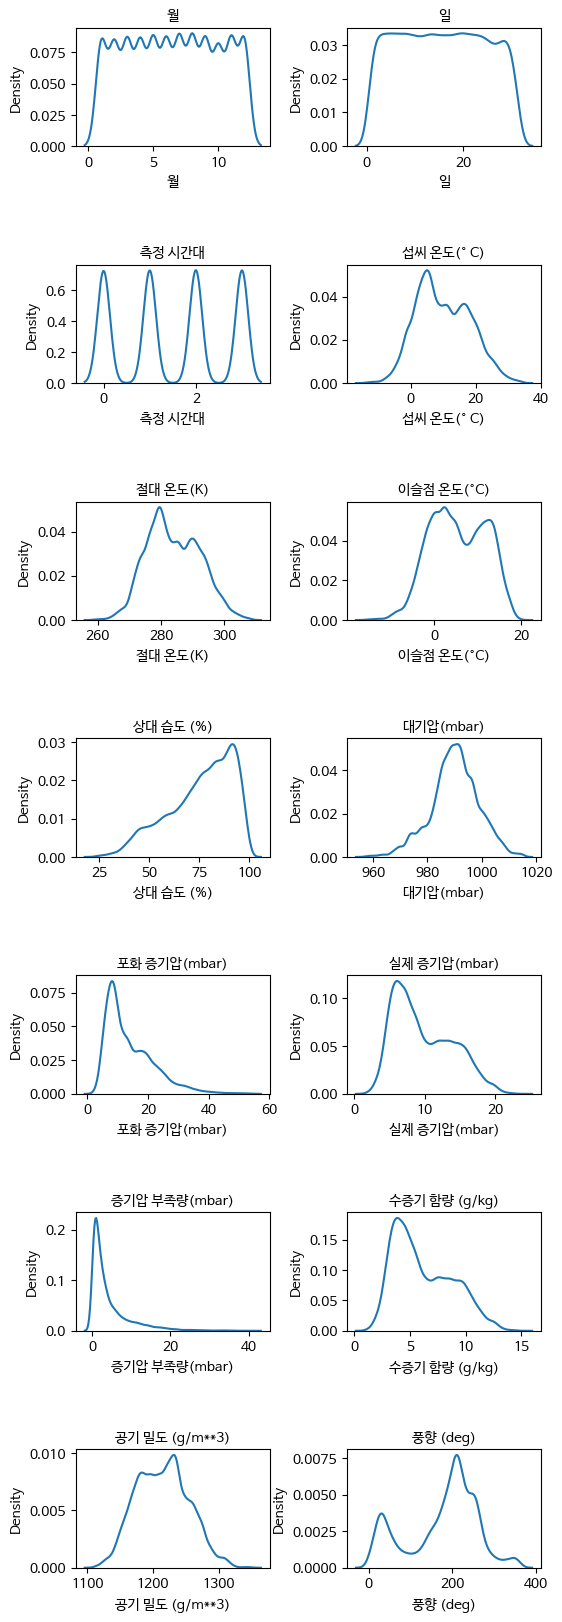

In [4]:
fig, ax = plt.subplots(7, 2, figsize=(6, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.
plt.subplots_adjust(wspace=0.4, hspace=1)
# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 0
columns = train_x.columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(data=train_x[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 14 :
            break


In [ ]:
# 1번째 정규화 방법, QuantileTransformer
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_X = scaler.transform(test_x)

# test_X가 최종 넣어야 할 test 데이터

In [ ]:
train_x = pd.DataFrame(train_x)
train_x.columns= columns

In [ ]:
test_X = pd.DataFrame(test_X)
test_X.columns= columns

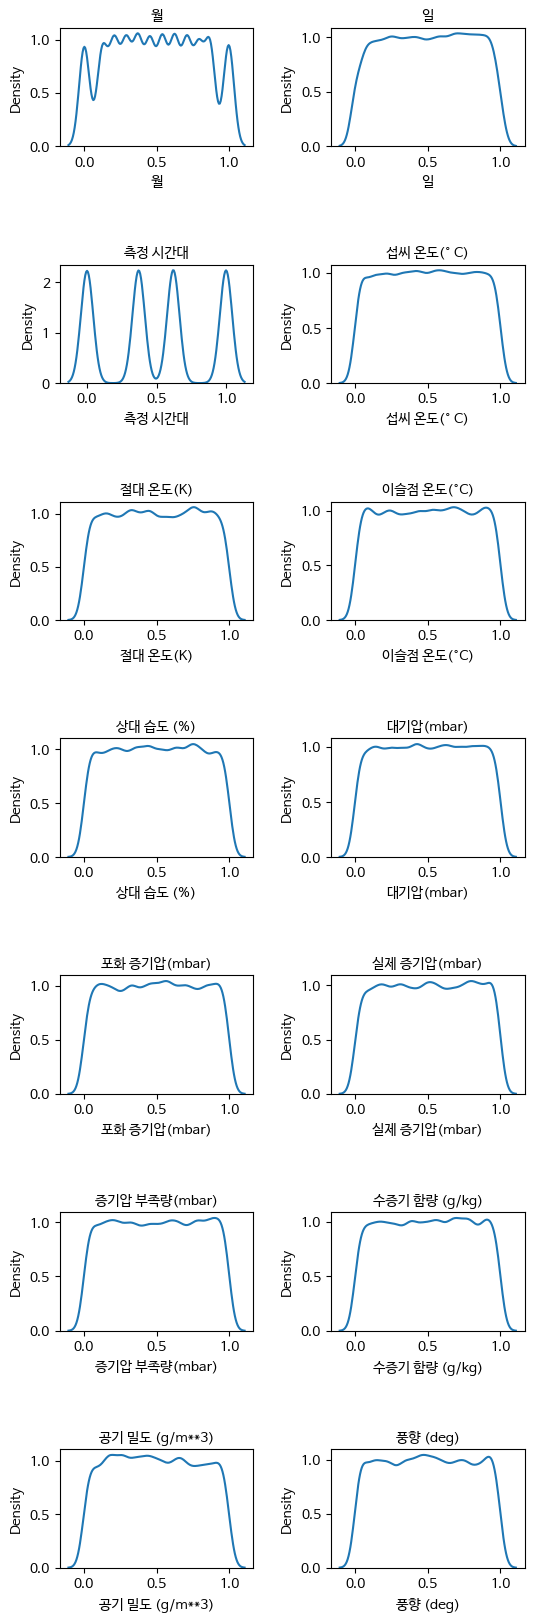

In [ ]:
fig, ax = plt.subplots(7, 2, figsize=(6, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.
plt.subplots_adjust(wspace=0.4, hspace=1)
# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 0
columns = train_x.columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(data=train_x[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 14 :
            break


In [ ]:
#PowerTransformer , 2번째 방법
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

train_x = pd.DataFrame(train_x)
train_x.columns= columns
test_x = pd.DataFrame(test_x)
test_x.columns= columns


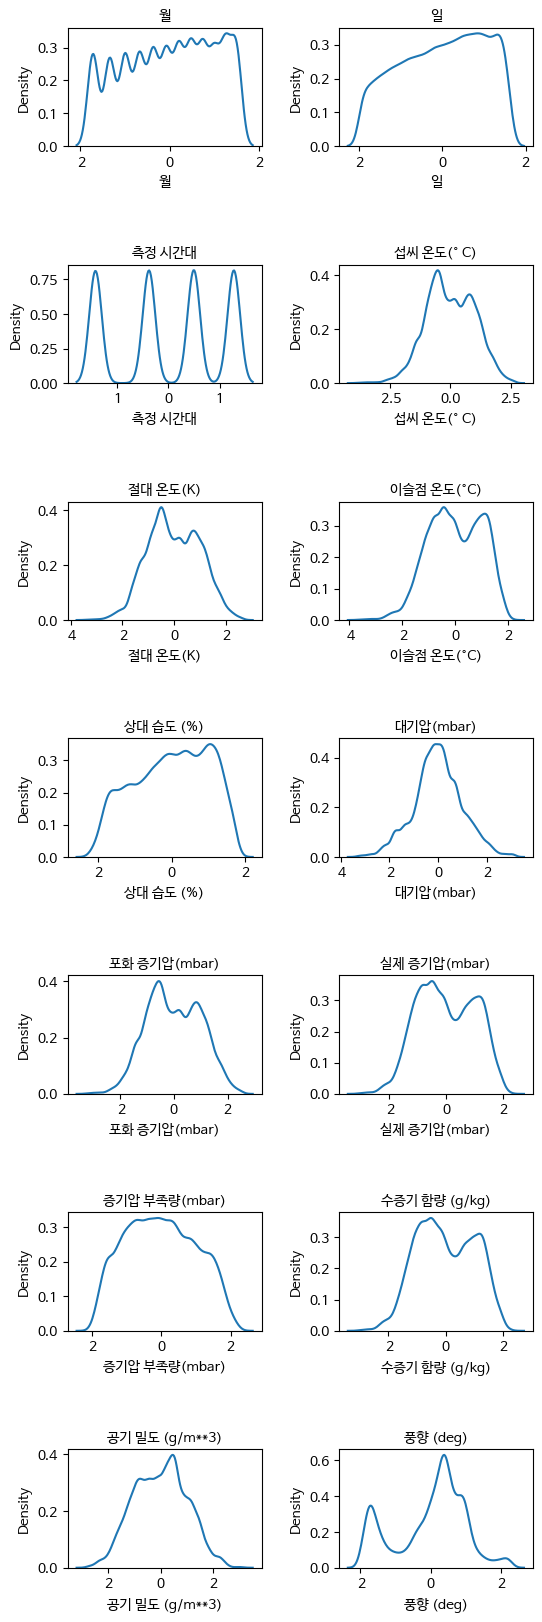

In [ ]:
fig, ax = plt.subplots(7, 2, figsize=(6, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.
plt.subplots_adjust(wspace=0.4, hspace=1)
# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 0
columns = train_x.columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(data=train_x[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 14 :
            break


In [5]:
# StandardScaler, 3번째 방법

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x = pd.DataFrame(train_x)
train_x.columns= columns
test_x = pd.DataFrame(test_x)
test_x.columns= columns


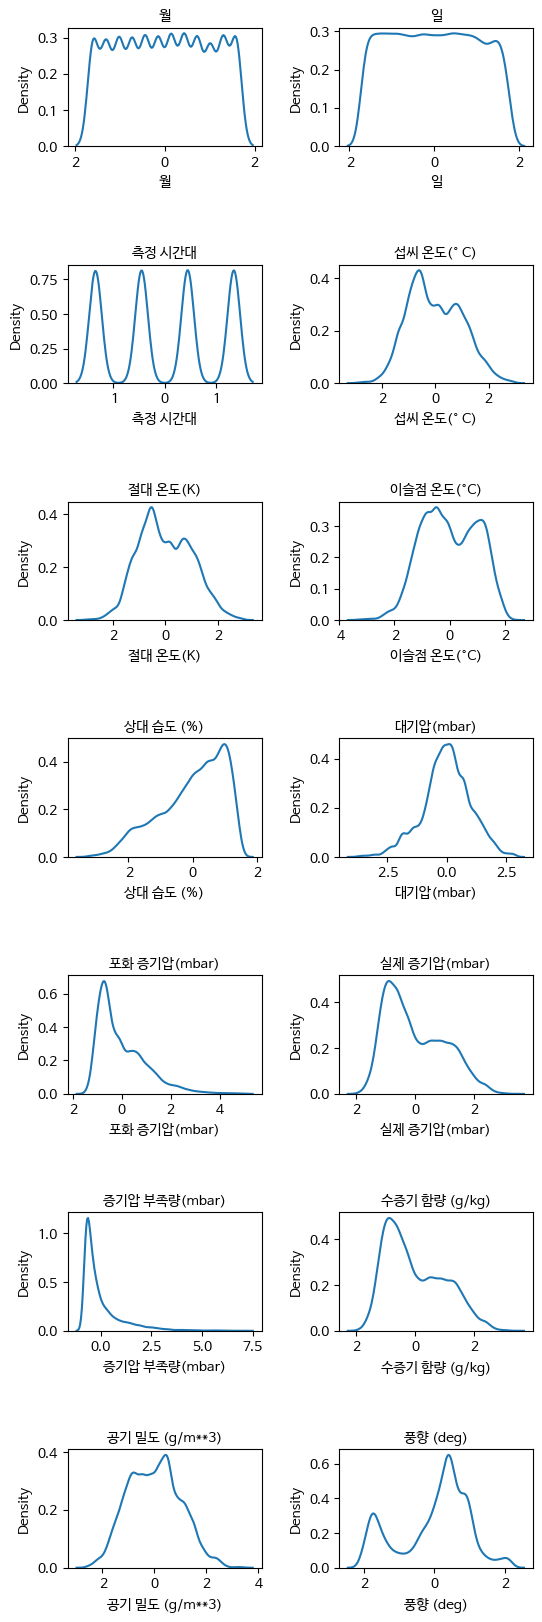

In [6]:
fig, ax = plt.subplots(7, 2, figsize=(6, 20))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.
plt.subplots_adjust(wspace=0.4, hspace=1)
# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 0
columns = train_x.columns
for row in range(7):
    for col in range(2):
        sns.kdeplot(data=train_x[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 14 :
            break


# 정규화 끝나면 Validation으로 데이터 나누기

In [ ]:
# 얘는 gridsearchcv, randomizedsearchcv 안 쓸 때만 해주기

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2023)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 그냥 SVM 사용해보기

In [ ]:
from sklearn import svm

# Create a svm Regressor
reg = svm.SVR(kernel='linear') # Linear Kernel

# Train the model using the training sets
reg.fit(train_x, train_y)

predictions = reg.predict(test_x)
# Create ID column
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)


# 회귀 모델

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
random_state=2023
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lgb = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lgb, rdforest]

NameError: ignored

# GridSearch 이용해서 lgb 학습 시키기

In [ ]:

param_lgb = {"learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5],
             "max_depth" : [1, 3, 5, 7, 9, 25, 50, 75],
             "num_leaves" : [100,300,500,900,1200],
             "n_estimators" : [100, 200, 300,500,800,1000],
             "learning_rate" : [0.01,0.1,0.2,0.3,0.4,0.5],
             "loss":['squared_error', 'absolute_error', 'huber', 'quantile']
              }



gscv_lgb = GridSearchCV (estimator = lgb, param_grid = param_lgb, scoring ='neg_mean_squared_error', cv = 3, refit=True, n_jobs=-1, verbose=2)
gscv_lgb.fit(train_x, train_y)
print('LGB 파라미터: ', gscv_lgb.best_params_)
print('LGB 예측 정확도: {:.4f}'.format(gscv_lgb.best_score_))

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=300; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=300; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=300; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=500; total time=   0.2s
[CV] END learning_rate=0.01, loss=squared_error, max_depth=1, n_estimators=100, num_leaves=500; total time=   1.4s
[CV] END learn

KeyboardInterrupt: ignored

In [ ]:
lgb_best = LGBMRegressor(learning_rate= 0.3, max_depth = 3, n_estimators = 100, num_leaves = 100, random_state=random_state, loss = 'squared_error')
lgb_best.fit(train_x,train_y)
predictions = lgb_best.predict(test_x)
# Create ID column
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)

# lgb 적용한 결과 파일 저장


# RandomSearch 이용해서 lgb 학습

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_lgb = {
    "learning_rate" : sp_uniform(0.01, 0.5),
    "max_depth" : sp_randint(1, 75),
    "num_leaves" : sp_randint(100, 1200),
    "n_estimators" : sp_randint(100, 1000),
    "loss": ['squared_error', 'absolute_error', 'huber', 'quantile']
}

# Randomized Search CV
rscv_lgb = RandomizedSearchCV(estimator = lgb, param_distributions = param_lgb, scoring ='neg_mean_squared_error', cv = 3, n_iter = 100, refit=True, n_jobs=-1, verbose=2, random_state=42)

rscv_lgb.fit(train_x, train_y)

print('LGB 파라미터: ', rscv_lgb.best_params_)
print('LGB 예측 정확도: {:.4f}'.format(rscv_lgb.best_score_))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
LGB 파라미터:  {'learning_rate': 0.05206998249752442, 'loss': 'quantile', 'max_depth': 36, 'n_estimators': 521, 'num_leaves': 203}
LGB 예측 정확도: -0.3691


In [ ]:
predictions = rscv_lgb.predict(test_x)
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)

# Random Search 이후 GridSearch 로 찾는 코드

In [10]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from sklearn.metrics import mean_absolute_error

# Define the parameter space for the random search
param_distribs = {
    'n_estimators': randint(low=50, high=200),
    'max_depth': randint(low=1, high=20),
    'num_leaves': randint(low=2, high=50),
    'min_child_samples': randint(low=5, high=100),
}

# Instantiate the model
lgbm = LGBMRegressor(random_state=2023)

# Perform the random search
rnd_search = RandomizedSearchCV(lgbm, param_distributions=param_distribs,
                                n_iter=80, cv=5, scoring='neg_mean_absolute_error', random_state=2023, n_jobs=-1)
rnd_search.fit(train_x, train_y)

# Get the best parameters from the random search
best_params_rnd = rnd_search.best_params_
print("Best parameters from random search: ", best_params_rnd)

# Define the parameter space for the grid search based on the results of the random search
param_grid = [
    {'n_estimators': [best_params_rnd['n_estimators'] - 10, best_params_rnd['n_estimators'], best_params_rnd['n_estimators'] + 10],
     'max_depth': [best_params_rnd['max_depth'] - 1, best_params_rnd['max_depth'], best_params_rnd['max_depth'] + 1],
     'num_leaves': [best_params_rnd['num_leaves'] - 2, best_params_rnd['num_leaves'], best_params_rnd['num_leaves'] + 2],
     'min_child_samples': [best_params_rnd['min_child_samples'] - 5, best_params_rnd['min_child_samples'], best_params_rnd['min_child_samples'] + 5]},
]

# Perform the grid search
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_x, train_y)
print('LGB 예측 정확도: {:.4f}'.format(grid_search.best_score_))
# Get the best parameters from the grid search
best_params_grid = grid_search.best_params_
print("Best parameters from grid search: ", best_params_grid)

# Train the model with the best parameters
final_model = LGBMRegressor(**best_params_grid)
final_model.fit(train_x, train_y)

# Make predictions on the test set
predictions = final_model.predict(test_x)



ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)


Best parameters from random search:  {'max_depth': 18, 'min_child_samples': 54, 'n_estimators': 164, 'num_leaves': 45}
LGB 예측 정확도: -0.5258
Best parameters from grid search:  {'max_depth': 18, 'min_child_samples': 49, 'n_estimators': 174, 'num_leaves': 47}


# RandomForest 적용

In [ ]:
param_rd = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

gscv_rd = GridSearchCV (estimator = rdforest, param_grid = param_rd, scoring ='neg_mean_squared_error', cv = 3, refit=True, n_jobs=1, verbose=2)
gscv_rd.fit(train_x, train_y)
print('RDforest 파라미터: ', gscv_rd.best_params_)


In [ ]:
rd_best = RandomForestRegressor(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators=150, bootstrap = False, max_features = 'sqrt')
rd_best.fit(train_x,train_y)
predictions = rd_best.predict(test_x)
# Create ID column
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/HousePrice/sample_submission.csv', index=False)

# random forest regressor 적용한 결과 파일 저장

#-> 피처 일부 제거해서 rd 적용하는게 가장 성능 현재까지 좋게 나옴

# RandomSearch를 통해 RandomForest 적용

In [ ]:
param = {
    'max_depth':range(1, 21),
    'max_leaf_nodes':range(5, 101, 5),
    'criterion':['squared_error','absolute_error'],
}
n_iter = 80

rs_rf = RandomizedSearchCV(rdforest,
                        param_distributions=param,
                        n_iter=n_iter,
                        cv=5,
                        n_jobs=-1)
rs_rf.fit(train_x, train_y)

predictions = rs_rf.predict(test_x)
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)

KeyboardInterrupt: ignored

In [8]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the parameter space for the random search
param_distribs = {
    'n_estimators': randint(low=50, high=200),
    'max_depth': randint(low=1, high=20),
    'max_features': randint(low=1, high=8),
}

# Instantiate the model
rdforest = RandomForestRegressor(random_state=2023)

# Perform the random search
rnd_search = RandomizedSearchCV(rdforest, param_distributions=param_distribs,
                                n_iter=80, cv=5, scoring='neg_mean_absolute_error', random_state=2023, n_jobs=-1)
rnd_search.fit(train_x, train_y)

# Get the best parameters from the random search
best_params_rnd = rnd_search.best_params_

# Define the parameter space for the grid search based on the results of the random search
param_grid = [
    {'n_estimators': [best_params_rnd['n_estimators'] - 10, best_params_rnd['n_estimators'], best_params_rnd['n_estimators'] + 10],
     'max_depth': [best_params_rnd['max_depth'] - 1, best_params_rnd['max_depth'], best_params_rnd['max_depth'] + 1],
     'max_features': [best_params_rnd['max_features'] - 1, best_params_rnd['max_features'], best_params_rnd['max_features'] + 1]},
]

# Perform the grid search
grid_search = GridSearchCV(rdforest, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_x, train_y)

# Get the best parameters from the grid search
best_params_grid = grid_search.best_params_

print('Random Forest 예측 정확도: {:.4f}'.format(grid_search.best_score_))

# Train the model with the best parameters
final_model = RandomForestRegressor(**best_params_grid)
final_model.fit(train_x, train_y)

# Make predictions on the test set
predictions = final_model.predict(test_x)
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)


# XGBoost 사용하는 코드

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

# Define the parameter space for the random search
param_distribs = {
    'n_estimators': randint(low=50, high=200),
    'max_depth': randint(low=1, high=20),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'min_child_weight': randint(low=1, high=10),
}

# Instantiate the model
xgb = XGBRegressor(random_state=2023)

# Perform the random search
rnd_search = RandomizedSearchCV(xgb, param_distributions=param_distribs,
                                n_iter=80, cv=5, scoring='neg_mean_absolute_error', random_state=2023, n_jobs=-1)
rnd_search.fit(train_x, train_y)

# Get the best parameters from the random search
best_params_rnd = rnd_search.best_params_
print("Best parameters from random search: ", best_params_rnd)

# Define the parameter space for the grid search based on the results of the random search
param_grid = [
    {'n_estimators': [best_params_rnd['n_estimators'] - 10, best_params_rnd['n_estimators'], best_params_rnd['n_estimators'] + 10],
     'max_depth': [best_params_rnd['max_depth'] - 1, best_params_rnd['max_depth'], best_params_rnd['max_depth'] + 1],
     'learning_rate': [best_params_rnd['learning_rate'] - 0.01, best_params_rnd['learning_rate'], best_params_rnd['learning_rate'] + 0.01],
     'min_child_weight': [best_params_rnd['min_child_weight'] - 1, best_params_rnd['min_child_weight'], best_params_rnd['min_child_weight'] + 1]},
]

# Perform the grid search
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_x, train_y)
print('XGB 예측 정확도: {:.4f}'.format(grid_search.best_score_))

# Get the best parameters from the grid search
best_params_grid = grid_search.best_params_
print("Best parameters from grid search: ", best_params_grid)

# Train the model with the best parameters
final_model = XGBRegressor(**best_params_grid)
final_model.fit(train_x, train_y)


print('예측 정확도: {:.4f}'.format(grid_search.best_score_))

# Make predictions on the test set
predictions = final_model.predict(test_x)

ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)


Best parameters from random search:  {'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 5, 'n_estimators': 193}


KeyboardInterrupt: ignored

# Gradient Boosting Regressor 사용

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

# Define the parameter space for the random search
param_distribs = {
    'n_estimators': randint(low=50, high=200),
    'max_depth': randint(low=1, high=20),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'min_samples_split': randint(low=2, high=10),
}

# Instantiate the model
gbr = GradientBoostingRegressor(random_state=2023)

# Perform the random search
rnd_search = RandomizedSearchCV(gbr, param_distributions=param_distribs,
                                n_iter=80, cv=5, scoring='neg_mean_absolute_error', random_state=2023, n_jobs=-1)
rnd_search.fit(train_x, train_y)

# Get the best parameters from the random search
best_params_rnd = rnd_search.best_params_
print("Best parameters from random search: ", best_params_rnd)

# Define the parameter space for the grid search based on the results of the random search
param_grid = [
    {'n_estimators': [best_params_rnd['n_estimators'] - 10, best_params_rnd['n_estimators'], best_params_rnd['n_estimators'] + 10],
     'max_depth': [best_params_rnd['max_depth'] - 1, best_params_rnd['max_depth'], best_params_rnd['max_depth'] + 1],
     'learning_rate': [best_params_rnd['learning_rate'] - 0.01, best_params_rnd['learning_rate'], best_params_rnd['learning_rate'] + 0.01],
     'min_samples_split': [best_params_rnd['min_samples_split'] - 1, best_params_rnd['min_samples_split'], best_params_rnd['min_samples_split'] + 1]},
]

# Perform the grid search
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_x, train_y)
print('Gradient Boosting Regressor 예측 정확도: {:.4f}'.format(grid_search.best_score_))

# Get the best parameters from the grid search
best_params_grid = grid_search.best_params_
print("Best parameters from grid search: ", best_params_grid)

# Train the model with the best parameters
final_model = GradientBoostingRegressor(**best_params_grid)
final_model.fit(train_x, train_y)

# Make predictions on the test set
predictions = final_model.predict(test_x)

ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)


# Bayesian Optimization을 사용해서 RandomForest 하이퍼파라미터 튜닝

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

# Define the function to optimize
def rf_cv(n_estimators, max_depth, max_features, data, targets):
    estimator = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        max_features=int(max_features),
        random_state=2023,
        n_jobs=-1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_mean_absolute_error', cv=5)
    return cval.mean()

def optimize_rf(data, targets):
    def rf_crossval(n_estimators, max_depth, max_features):
        # Wrapping the cross-validation call for optimization
        return rf_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            max_features=int(max_features),
            data=data,
            targets=targets
        )

    optimizer = BayesianOptimization(
        f=rf_crossval,
        pbounds={
            "n_estimators": (50, 200),
            "max_depth": (1, 20),
            "max_features": (1, 8),
        },
        random_state=2023,
    )
    optimizer.maximize(n_iter=15, init_points=5)

    return optimizer

optimizer = optimize_rf(train_x, train_y)

# Print the best parameters and the corresponding accuracy
print('Random Forest 최적 파라미터: ', optimizer.max['params'])
print('Random Forest 예측 정확도: {:.4f}'.format(optimizer.max['target']))

# Train the model with the best parameters
final_model = RandomForestRegressor(n_estimators=int(optimizer.max['params']['n_estimators']), max_depth=int(optimizer.max['params']['max_depth']), max_features=int(optimizer.max['params']['max_features']), random_state=2023, n_jobs=-1)
final_model.fit(train_x, train_y)

# Make predictions on the test set
predictions = final_model.predict(test_x)
ID = ['TEST_{:05d}'.format(i) for i in range(len(test_x))]

# Save the predictions to a CSV file
submission = pd.DataFrame({'ID': ID, '풍속 (m/s)': predictions})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 풍속 예측/sample_submission.csv', index=False)
